<a href="https://colab.research.google.com/github/Kuliah-Machine-Learning/2021-Batik-Kel-5/blob/main/Klasifikasi-Batik_Kel5_VGG-16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Library yang Dibutuhkan

In [1]:
!pip install slidingwindow
import slidingwindow as sw

from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

Mengambil dataset dari GitHub

In [2]:
!apt-get install subversion > /dev/null
!svn export https://github.com/Kuliah-Machine-Learning/2021-Batik-Kel-5.git/trunk/data/ > /dev/null

Menampilkan Dataset

In [3]:
!ls data/train/Kawung
!ls data/train/Tumpal
!ls data/train/Meander
!ls data/train/Pilin
!ls data/test/Kawung
!ls data/test/Tumpal
!ls data/test/Meander
!ls data/test/Pilin

K100.jpg  K129.jpg  K157.jpg  K185.jpg	K212.jpg  K240.jpg  K50.jpg  K79.jpg
K101.jpg  K12.jpg   K158.jpg  K186.jpg	K213.jpg  K241.jpg  K51.jpg  K7.jpg
K102.jpg  K130.jpg  K159.jpg  K187.jpg	K214.jpg  K24.jpg   K52.jpg  K80.jpg
K103.jpg  K131.jpg  K15.jpg   K188.jpg	K215.jpg  K25.jpg   K53.jpg  K81.jpg
K104.jpg  K132.jpg  K160.jpg  K189.jpg	K216.jpg  K26.jpg   K54.jpg  K82.jpg
K105.jpg  K133.jpg  K161.jpg  K18.jpg	K217.jpg  K27.jpg   K55.jpg  K83.jpg
K106.jpg  K134.jpg  K162.jpg  K190.jpg	K218.jpg  K28.jpg   K56.jpg  K84.jpg
K107.jpg  K135.jpg  K163.jpg  K191.jpg	K219.jpg  K29.jpg   K57.jpg  K85.jpg
K108.jpg  K136.jpg  K164.jpg  K192.jpg	K21.jpg   K2.jpg    K58.jpg  K86.jpg
K109.jpg  K137.jpg  K165.jpg  K193.jpg	K220.jpg  K30.jpg   K59.jpg  K87.jpg
K10.jpg   K138.jpg  K166.jpg  K194.jpg	K221.jpg  K31.jpg   K5.jpg   K88.jpg
K110.jpg  K139.jpg  K167.jpg  K195.jpg	K222.jpg  K32.jpg   K60.jpg  K89.jpg
K111.jpg  K13.jpg   K168.jpg  K196.jpg	K223.jpg  K33.jpg   K61.jpg  K8.jpg
K112.jpg  K140.

Menampilkan Sample Dataset Train

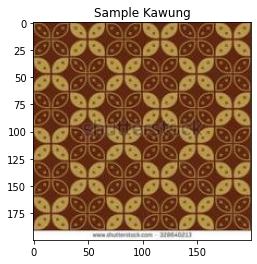

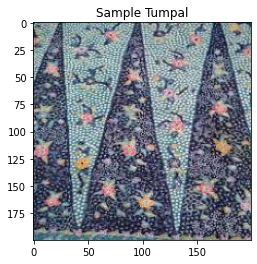

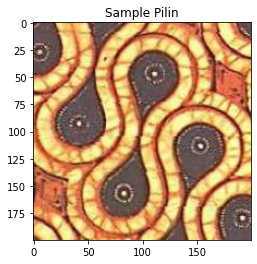

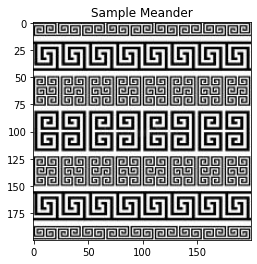

In [4]:
plt.title("Sample Kawung")
plt.imshow(imread("data/train/Kawung/K4.jpg"))
plt.show()

plt.title("Sample Tumpal")
plt.imshow(imread("data/train/Tumpal/T7.jpg"))
plt.show()

plt.title("Sample Pilin")
plt.imshow(imread("data/train/Pilin/P11.jpg"))
plt.show()

plt.title("Sample Meander")
plt.imshow(imread("data/train/Meander/M4.jpg"))
plt.show()

Membuat "Patches" dari Dataset dengan Metode Sliding Window dengan ukuran 200*200px (Batal karena tidak berhasil sehingga diubah manual)

In [5]:
#def save_to_folder(img_path,directory,size=200,overlap=0.4):
    #Membaca gambar path penyimpanan window ke direktori/file yang spesifik
    #img = imread(img_path)
    #basename = os.path.basename(img_path)
    #fname = os.path.splitext(basename)[0]
    #windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, size, overlap)
    #for i,window in enumerate(windows):
     #   ii = str("{0:05d}".format(i))
      #  _fname = fname + "_" + ii + ".jpg"
       # _img = img[window.indices()]
        #if _img.shape !=(size,size,3):
         #   continue
        #img_target_path = os.path.join(directory,_fname)
        
        #imsave(img_target_path,_img, check_contrast=False)

#files = os.listdir("data/train/Kawung/")
#files = [x for x in files if x.endswith(".jpg")]

#Menyimpan gambar yang telah dicacah pada folder chopped
#for file in files:
#    save_directory = "data/chopped/Kawung/"
 #   file = os.path.join("data/train/Kawung/",file)
 #   save_to_folder(file,save_directory)

Memuat Dataset

In [6]:
IMAGE_SIZE = 200
BATCH_SIZE = 128
base_dir = os.path.join('data/train')

#Memuat dataset train/pelatihan
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

#Memuat dataset test
X_test = []
y_test = []
labels = ['Kawung', 'Tumpal']

for i,label in enumerate(labels):
    folder = os.path.join("data/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(200,200))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan Dataset dalam bentuk Array
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 549 images belonging to 4 classes.
Found 135 images belonging to 4 classes.
Bentuk array dari dataset train (pelatihan) adalah: (128, 200, 200, 3) (128, 4)
Bentuk array dari dataset validation (validasi) adalah: (128, 200, 200, 3) (128, 4)
Bentuk array dari dataset test (pengujian) adalah: (41, 200, 200, 3) (41,)
